## Homework 08: Classification

**Due:** Midnight on March 23 (with a 2-hour grace period)  


### Overview

In this final homework before starting our course project, we will introduce the essential machine learning paradigm of **classification**. We will work with a well-known Kaggle dataset—the Pima Indians Diabetes dataset—to determine whether an individual has diabetes (1) or not (0). This is a binary classification task.

As we’ve discussed in this week’s lessons, the classification workflow is similar to what we’ve done for regression, with a few key differences:
- Instead of `RepeatedKFold` we use `RepeatedStratifiedKFold` (read the docs to understand the difference)
- We use classification metrics (e.g., accuracy, precision, recall, F1-score) instead of regression metrics--for simplicity we'll just use accuracy in this homework. 

For this assignment, you’ll build two models and measure their performance using the accuracy metric. 
1. A **logistic regression** classifier as a baseline.
2. One of the **ensemble** classifiers of your choice.

Because we’ve already covered much of the workflow in our regression assignments, this homework is intentionally concise and less prescriptive.

### Grading

There are 5 graded problems, each worth 5 points, for a total of 25 points.

In [2]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,GridSearchCV
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.preprocessing   import StandardScaler
from tqdm                    import tqdm

from collections import Counter

# globals

random_state = 42


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem One:  Load, Explore, and Preprocess the Kaggle Pima Indians Diabetes Dataset 

In the follow cell(s), 
- Download the dataset from Kaggle
- Perform some simple EDA using `.head()`, `.info()` and `.hist()`
    - When using a classification dataset, **always** look to see whether the target is balanced (approximately equal numbers of classes) or not. 
- Create the feature set `X` and the target set `y` (using `Outcome` as the target)
- Scale `X` using `StandardScalar` (since the classification models often prefer this)
- Split the dataset into 80% training and 20% testing sets
- Verify that the graded answer is correct

In [3]:
# Your code here
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print(path)
df = pd.read_csv(os.path.join(path,'diabetes.csv'))
df.head()


/home/codespace/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


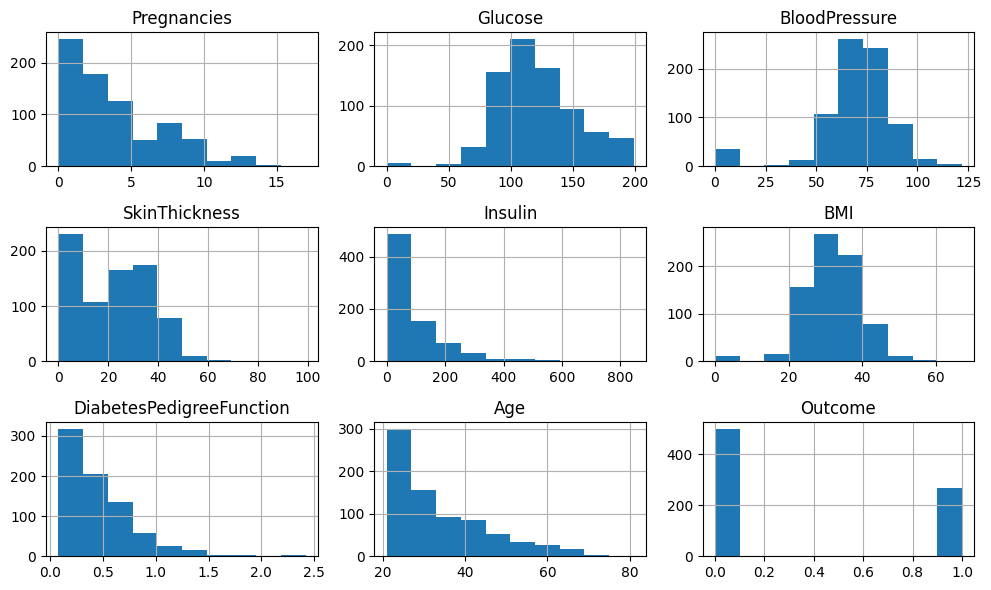

In [5]:
df.hist(figsize=(10,6))
plt.tight_layout()
None

In [5]:
X = df.drop(columns="Outcome")
y = df["Outcome"]

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
standardScale_ = StandardScaler()
X_train = standardScale_.fit_transform(X_train)
X_test = standardScale_.fit_transform(X_test)

### Problem 1 Graded Answer

In [9]:
# Nothing to do, but you might want to check and make sure this is correct

a1 = (X_train.shape,X_test.shape)                          

print(f'a1 = {a1}')              # Do not change this line, and DO NOT print anything else in this cell

a1 = ((614, 8), (154, 8))


## Interlude: Wrapper Functions for Running Classification Models

The following cells are adapted from the Week 7 homework in order to use accuracy as the error metric. You can easily modify these
if you wish to consider other metrics.  


**Note:** `sweep_parameter` sets `X_train` etc. to default values using the global values for `X_train` etc. you created in problem 1.  Should work fine as is, but you can always just ignore the defaults and assign the parameters explicitly. 


In [6]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = model.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


In [12]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
                   ):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy = mean_cv_accuracy
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # Use only as many parameter values as computed
        partial_param_list = parameter_list[:len(cv_accuracies)]
        
        # Check if our parameter list is Boolean for proper labeling
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Accuracy -----
        ax1.set_title(f"Accuracy vs {param}")
        
        ax1.plot(x_vals,
                 cv_accuracies,
                 marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals,
                 train_accuracies,
                 marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals,
                 test_accuracies,
                 linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]],
                    [max_cv_accuracy],
                    marker='x', label="Best CV Accuracy", color='red')
        
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Accuracy Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


## Problem Two: Classification using Logistic Regression (Baseline)  

For this problem,
- Read the docs for `LogisticRegression`
- Run the model with `class_weight = 'balanced'` and `max_iter=1000` using `run_model` or just your own code. 
- Answer the graded questions

In [12]:
# Your code; add as many cells as you need
param_grid_log = {
    'class_weight' : 'balanced',
    'max_iter' : 1000,
    'random_state' : 42
}

mean_cv_acc, std_cv_acc, train_acc, test_acc = run_model(LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_repeats=10, n_jobs=-1, **param_grid_log)
print("Mean CV Acc " + str(mean_cv_acc))
print("STD CV Acc " + str(std_cv_acc))
print("Train Acc " + str(train_acc))
print("Test Acc " + str(test_acc))


Mean CV Acc 0.7526016260162602
STD CV Acc 0.02909396694415608
Train Acc 0.760586319218241
Test Acc 0.7142857142857143


### Problem 2.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [13]:
# Insert the mean CV accuracy

a2a = mean_cv_acc                             # Just to get it to run without errors, put your answer here                       

print(f'a2a = {a2a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = 0.7526


### Problem 2.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [14]:
# Insert the test accuracy

a2b = test_acc                               # Just to get it to run without errors, put your answer here                          

print(f'a2b = {a2b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = 0.7143


## Problem Three: Classification using Ensemble Methods  

For this problem,
- Choose one of the ensemble methods for classification (see the first code cell above)
- Read about the hyperparameters for the model in the `sklearn` docs
- Tune the model for best performance using the wrapper functions and/or grid search as needed
- Answer the graded questions


In [13]:
#make a new split with unscaled X since decision trees do not use scaling
X_train_unscaled,X_test_unscaled,y_train_unscaled,y_test_unscaled = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
print(X_train_unscaled.info)

<bound method DataFrame.info of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
60             2       84              0              0        0   0.0   
618            9      112             82             24        0  28.2   
346            1      139             46             19       83  28.7   
294            0      161             50              0        0  21.9   
231            6      134             80             37      370  46.2   
..           ...      ...            ...            ...      ...   ...   
71             5      139             64             35      140  28.6   
106            1       96            122              0        0  22.4   
270           10      101             86             37        0  45.6   
435            0      141              0              0        0  42.4   
102            0      125             96              0        0  22.5   

     DiabetesPedigreeFunction  Age  
60                      0.304   21  
618  

In [ ]:


# Updated parameter grid with valid criteria for classifiers
param_grid_rf = {
    'n_estimators': list(range(1,100,30)),  # use valid classifier criteria
    'max_features': list(range(1,8,3)),
    'max_depth' : list(range(1,46,15)),
    'bootstrap': [True,False],
}

# Set n_jobs=-1 to use all available CPU cores
grid_dt = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,        # leverage all available cores
)

sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10

grid_dt.fit(X_train_unscaled, y_train_unscaled)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_unscaled)

print(f"Best Parameters: {grid_dt.best_params_}\n")
print(f"Cross-Validation Accuracy: {grid_dt.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")



Best Parameters: {'bootstrap': False, 'max_depth': 16, 'max_features': 1, 'n_estimators': 91}

Cross-Validation Accuracy: 0.7818
Test Accuracy: 0.7143


In [32]:


# Updated parameter grid with valid criteria for classifiers
param_grid_rf = {
    'n_estimators': list(range(200,300,10)),  # use valid classifier criteria
    'max_features': list(range(1,8,1)),
    'max_depth' : list(range(10,25,1)),
    'bootstrap': [False],
}

# Set n_jobs=-1 to use all available CPU cores
grid_dt = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,        # leverage all available cores
)

grid_dt.fit(X_train_unscaled, y_train_unscaled)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_unscaled)

print(f"Best Parameters: {grid_dt.best_params_}\n")
print(f"Cross-Validation Accuracy: {grid_dt.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")



Best Parameters: {'bootstrap': False, 'max_depth': 13, 'max_features': 3, 'n_estimators': 290}

Cross-Validation Accuracy: 0.7817
Test Accuracy: 0.7532


In [19]:


# Updated parameter grid with valid criteria for classifiers
param_grid_rf = {
    'n_estimators': list(range(850,1001,30)),  # use valid classifier criteria
    'max_features': list(range(1,8,1)),
    'max_depth' : list(range(10,25,2)),
    'bootstrap': [False],
}

# Set n_jobs=-1 to use all available CPU cores
grid_dt = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,        # leverage all available cores
)

grid_dt.fit(X_train_unscaled, y_train_unscaled)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_unscaled)

print(f"Best Parameters: {grid_dt.best_params_}\n")
print(f"Cross-Validation Accuracy: {grid_dt.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")



Best Parameters: {'bootstrap': False, 'max_depth': 14, 'max_features': 3, 'n_estimators': 880}

Cross-Validation Accuracy: 0.7785
Test Accuracy: 0.7338


Sweeping n_estimators: 100%|██████████| 10/10 [06:51<00:00, 41.13s/it]


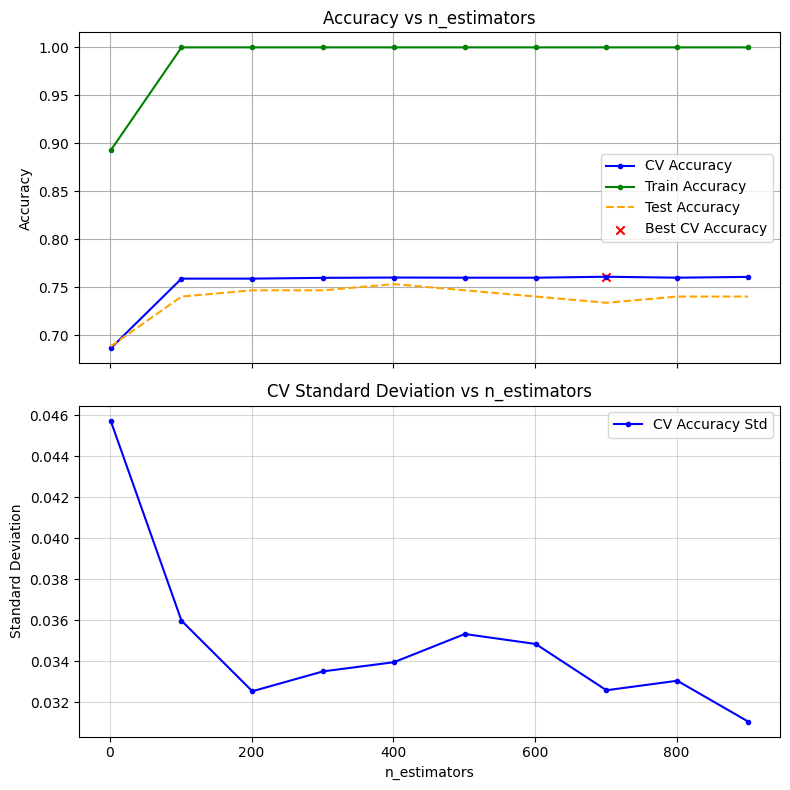

Execution Time: 00:06:51


{'n_estimators': 701,
 'max_features': None,
 'max_depth': None,
 'bootstrap': True,
 'random_state': 42,
 'accuracy_found': np.float64(0.7609009729441557)}

In [24]:
Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
}

sweep_parameter(RandomForestClassifier,
                    Default_Parameters_Random_Forests,
                    'n_estimators',
                    range(1,1001,100),
                    X_train          = X_train_unscaled,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train_unscaled,
                    X_test           = X_test_unscaled,
                    y_test           = y_test_unscaled,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
)



Sweeping n_estimators: 100%|██████████| 11/11 [11:39<00:00, 63.63s/it]


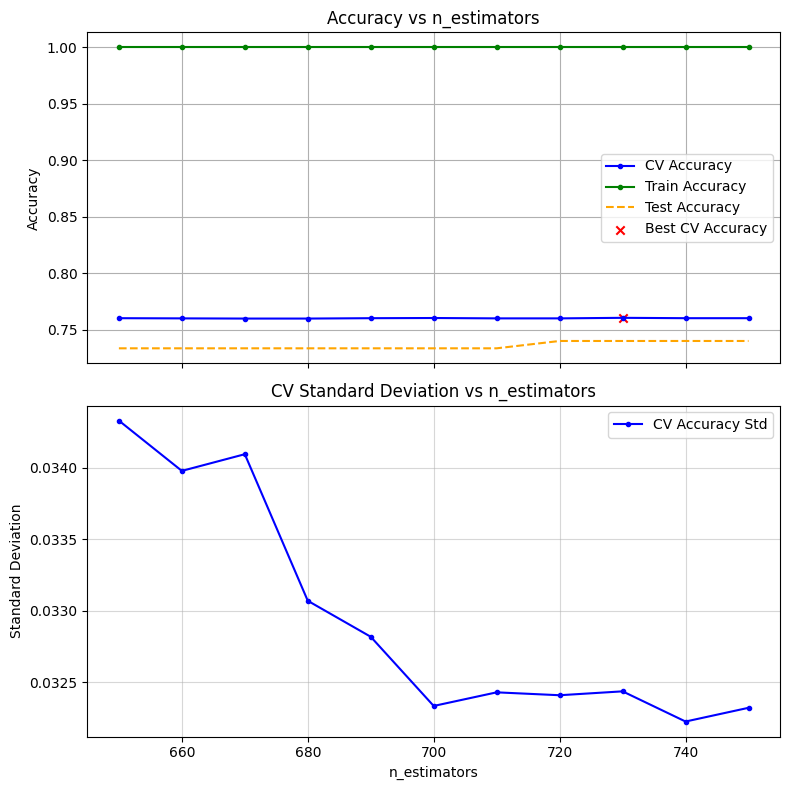

Execution Time: 00:11:40


{'n_estimators': 730,
 'max_features': None,
 'max_depth': None,
 'bootstrap': True,
 'random_state': 42,
 'accuracy_found': np.float64(0.7607410369185659)}

In [25]:
Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
}

sweep_parameter(RandomForestClassifier,
                    Default_Parameters_Random_Forests,
                    'n_estimators',
                    range(650,751,10),
                    X_train          = X_train_unscaled,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train_unscaled,
                    X_test           = X_test_unscaled,
                    y_test           = y_test_unscaled,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
)



Sweeping max_features: 100%|██████████| 8/8 [07:28<00:00, 56.03s/it]


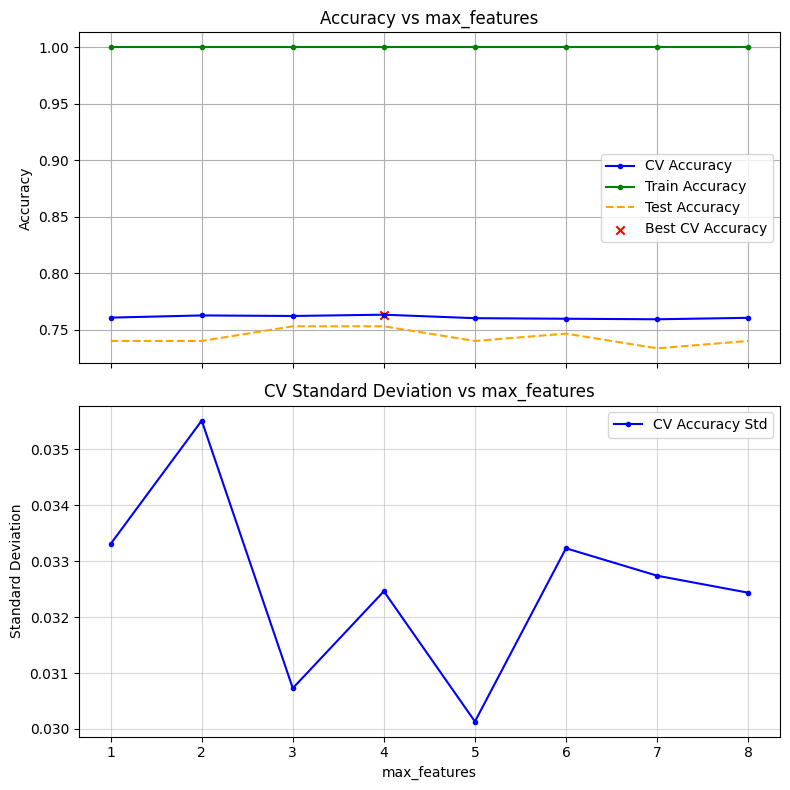

Execution Time: 00:07:28


{'n_estimators': 730,
 'max_features': 4,
 'max_depth': None,
 'bootstrap': True,
 'random_state': 42,
 'accuracy_found': np.float64(0.7635105957616953)}

In [31]:
Default_Parameters_Random_Forests = {
    'n_estimators': 730,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
}

sweep_parameter(RandomForestClassifier,
                    Default_Parameters_Random_Forests,
                    'max_features',
                    range(1,9,1),
                    X_train          = X_train_unscaled,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train_unscaled,
                    X_test           = X_test_unscaled,
                    y_test           = y_test_unscaled,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
)



Sweeping max_depth: 100%|██████████| 10/10 [08:35<00:00, 51.60s/it]


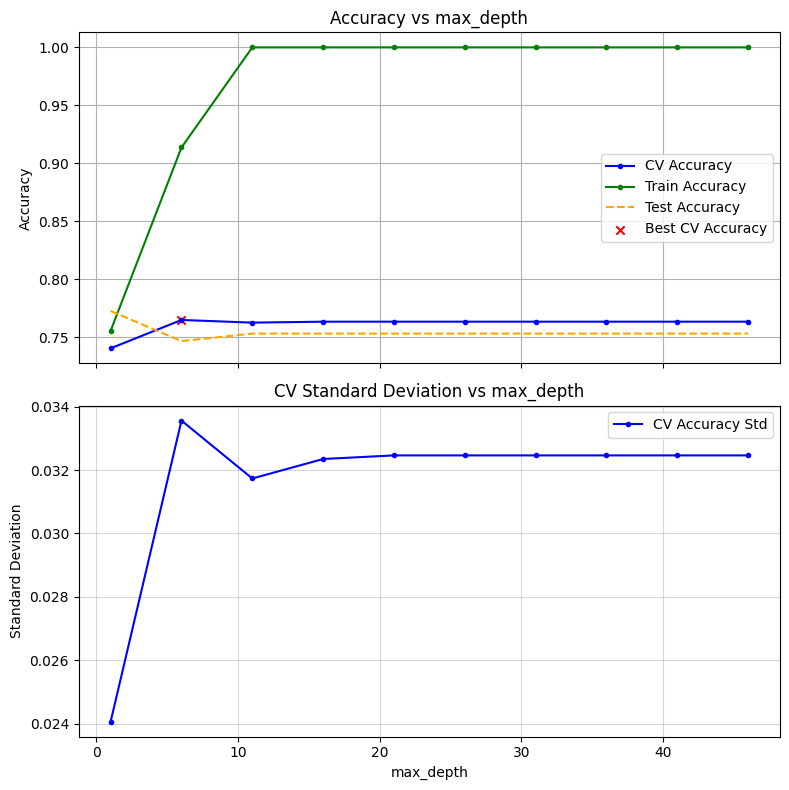

Execution Time: 00:08:36


{'n_estimators': 730,
 'max_features': 4,
 'max_depth': 6,
 'bootstrap': True,
 'random_state': 42,
 'accuracy_found': np.float64(0.7649860055977611)}

In [29]:

Default_Parameters_Random_Forests = {
    'n_estimators': 730,         # Number of base estimators in the ensemble
    'max_features': 4,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
}

sweep_parameter(RandomForestClassifier,
                    Default_Parameters_Random_Forests,
                    'max_depth',
                    range(1,51,5),
                    X_train          = X_train_unscaled,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train_unscaled,
                    X_test           = X_test_unscaled,
                    y_test           = y_test_unscaled,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
)



Sweeping max_depth: 100%|██████████| 8/8 [07:14<00:00, 54.26s/it]


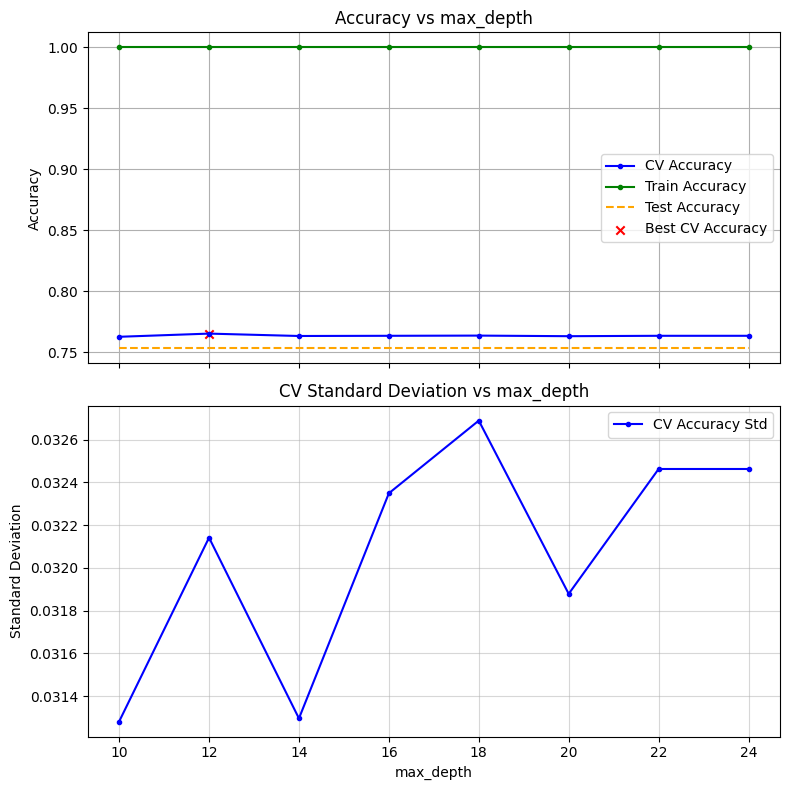

Execution Time: 00:07:14


In [33]:

Default_Parameters_Random_Forests = {
    'n_estimators': 730,         # Number of base estimators in the ensemble
    'max_features': 4,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
}

score = sweep_parameter(RandomForestClassifier,
                    Default_Parameters_Random_Forests,
                    'max_depth',
                    range(10,25,2),
                    X_train          = X_train_unscaled,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train_unscaled,
                    X_test           = X_test_unscaled,
                    y_test           = y_test_unscaled,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
)



In [35]:
print(score)

{'n_estimators': 730, 'max_features': 4, 'max_depth': 12, 'bootstrap': True, 'random_state': 42, 'accuracy_found': np.float64(0.7653045448487272)}


In [41]:
param_grid1 = {'n_estimators': 730, 'max_features': 4, 'max_depth': 12, 'bootstrap': True, 'random_state': 42}
mean_cv_acc, std_cv_acc, train_acc, test_acc = run_model(model=RandomForestClassifier, X_train=X_train_unscaled, y_train=y_train_unscaled, X_test=X_test_unscaled, y_test=y_test_unscaled, n_repeats=10, n_jobs=-1,**param_grid1)


### Problem 3.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [42]:
# Insert the mean CV accuracy

a3a = mean_cv_acc                             # Just to get this cell to run without errors, put your answer here                 

print(f'a3a = {a3a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = 0.7653


### Problem 3.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [43]:
# Insert the test accuracy

a3b = test_acc                             # Just to get this cell to run without errors, put your answer here 

print(f'a3b = {a3b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = 0.7532
